In [1]:
%%capture

!pip install transformers diffusers accelerate -U
!pip uninstall parediffusers -y
#!pip install parediffusers
!pip install -i https://test.pypi.org/simple/ parediffusers

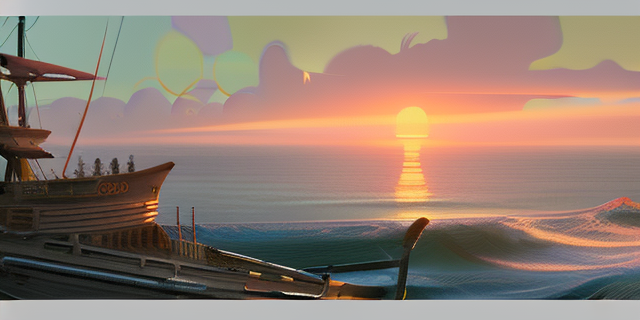

In [4]:
import torch
from PIL import Image
from parediffusers import PareDiffusionPipeline

pipe = PareDiffusionPipeline.from_pretrained(
	"stabilityai/stable-diffusion-2",
	device=torch.device("cuda"),
	dtype=torch.float16,
)

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt, width=640, height=320)
display(image)

In [5]:
def add_noise(
	pipe,
	original_samples: torch.FloatTensor,
	noise: torch.FloatTensor,
	timesteps: torch.IntTensor,
) -> torch.FloatTensor:
	# Make sure alphas_cumprod and timestep have same device and dtype as original_samples
	# Move the self.alphas_cumprod to device to avoid redundant CPU to GPU data movement
	# for the subsequent add_noise calls
	pipe.alphas_cumprod = pipe.alphas_cumprod.to(device=original_samples.device)
	alphas_cumprod = pipe.alphas_cumprod.to(dtype=original_samples.dtype)
	#timesteps = timesteps.to(original_samples.device)

	sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
	sqrt_alpha_prod = sqrt_alpha_prod.flatten()
	while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
		sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

	sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
	sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
	while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
		sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

	noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
	return noisy_samples

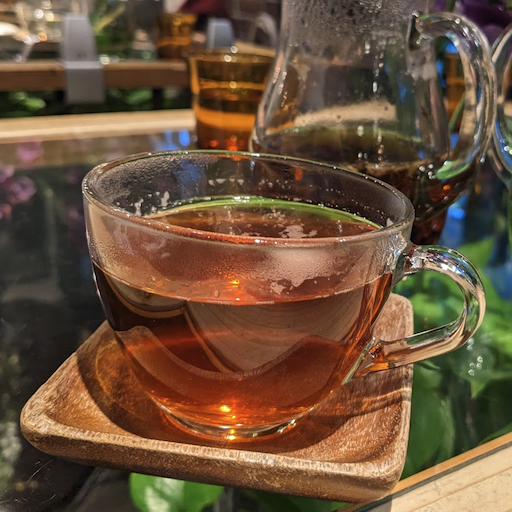

In [18]:
from PIL import Image
from torchvision.transforms.functional import to_tensor

seed = 42
init_image = Image.open("inputs/tea.png").convert("RGB")
init_image

In [19]:
init_image = to_tensor(init_image).unsqueeze(0)
init_image = init_image.to(device=pipe.device, dtype=pipe.dtype)

shape = init_image.shape
shape


In [20]:

shape = init_image.shape
shape

torch.Size([1, 3, 512, 512])

In [8]:
#import numpy as np
#import torch
#import torch.nn as nn
#from typing import Optional, Tuple
#from parediffusers.models.resnet import PareResnetBlock2D
#from parediffusers.models.unet_2d_get_blocks import pare_get_down_block
#from parediffusers.models.unet_2d_mid_blocks import PareUNetMidBlock2D
from parediffusers.models.vae_blocks import PareEncoder

encoder = PareEncoder(
	in_channels=4,
	out_channels=4,
	down_block_types=pipe.vae.config.down_block_types,
	block_out_channels=pipe.vae.config.block_out_channels,
	layers_per_block=pipe.vae.config.layers_per_block,
	double_z=False,
).to(device=pipe.device, dtype=pipe.dtype)
#encoder


In [21]:
#pipe.vae.encoder

In [22]:
generator = torch.Generator(device=pipe.device).manual_seed(seed)

# get latents
timesteps = pipe.retrieve_timesteps(50)
latent_timestep = timesteps[:1]

init_latents = pipe.vae.encoder(init_image / pipe.vae.config.scaling_factor)
init_latents.shape

torch.Size([1, 8, 64, 64])

In [23]:
init_latents = pipe.vae.config.scaling_factor * init_latents
init_latents.shape

torch.Size([1, 8, 64, 64])

In [24]:
noise = torch.randn(init_latents.shape, generator=generator, device=pipe.device, dtype=pipe.dtype)
noise.shape

torch.Size([1, 8, 64, 64])

In [25]:
latents = add_noise(pipe.scheduler, init_latents, noise, latent_timestep)
#latents = torch.mean(latents, dim=0, keepdim=True)
#latents = latents[1].unsqueeze(0)
#print(latents.shape)
#pipe.tensor_to_image(latents[0].cpu())

latents.shape

torch.Size([50, 8, 64, 64])

In [26]:
latents = latents[0].unsqueeze(0)
prompt = "a cup of tea"
prompt_embeds = pipe.encode_prompt(prompt)
latents = pipe.denoise(latents, prompt_embeds, 50, 7.5)
image = pipe.vae_decode(latents)
display(image)

RuntimeError: Given groups=1, weight of size [320, 4, 3, 3], expected input[2, 8, 64, 64] to have 4 channels, but got 8 channels instead